In [3]:
from keras.api.utils import to_categorical
from keras.api.callbacks import ModelCheckpoint, EarlyStopping
from keras.api.models import Sequential
from keras.api.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Rescaling, RandomRotation, RandomZoom
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import target_detection_hough
import pandas as pd
import utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from keras.api.layers import RandomRotation, RandomZoom
from keras import regularizers
from target_detection_hough import get_roi
from utils import show
from datetime import datetime
import cv2 as cv

In [4]:
def get_data(folder_path="../data"):
    file_names, file_labels = utils.load_image_paths_and_labels(folder_path)
    images = []
    labels = []
    for file, label in tqdm(zip(file_names, file_labels), total=len(file_labels)):
        # for file, label in tqdm(zip(file_names, file_labels[:2]), total=2):
        number_image, image, status = target_detection_hough.detect_target(
            utils.get_and_preprocess_image(file))
        # preprocess image funcion is added in the end this is not part of the used code
        _pre_processed_number_image = utils.preprocess_image(
            utils.img_edges(number_image), resize=False, crop=False, norm=True)
        if status:
            images.append(_pre_processed_number_image)
            labels.append(label)
    return np.array(images),  np.array(labels)


# x_data, y_data = get_data("../data")

In [5]:
# show(np.array(x_data[0],dtype=np.uint16)*255)

In [6]:
# print(x_data.shape, y_data.shape)
# x_data = x_data.reshape(1456, 150, 150, 1)
# show(x_data[0])
# y_data[0]
# print(x_data.shape, y_data.shape)

In [7]:
# df = pd.DataFrame({"images": x_data.tolist(), 'labels': y_data})
# df.to_pickle('./number_data_edges.pkl')

In [8]:
df:pd.DataFrame = pd.read_pickle('./number_data_edges.pkl')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  1456 non-null   object
 1   labels  1456 non-null   object
dtypes: object(2)
memory usage: 22.9+ KB
None


(150, 150, 1)


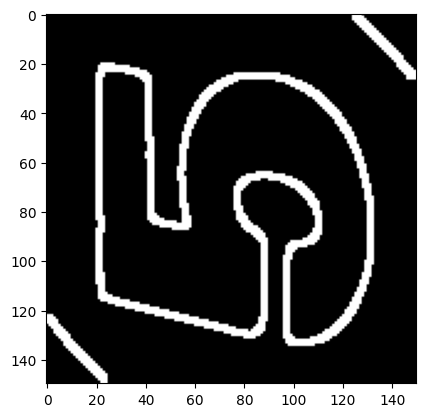

[[255], [255], [255], [255], [255], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [255], [255], [255], [255], [0], [0], [0], [0], [0], [0], [255], [255], [255], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [255], [255], [255], [255], [255], [255], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


In [9]:
print(np.array(df['images'][0]).shape)
show(np.array(df['images'][0],dtype=np.uint16))
print(max(df['images'][0]))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df['images'].values, df['labels'].values, test_size=0.2, random_state=46, shuffle=True)
X_validate, X_test, Y_validate, Y_test = train_test_split(
    X_test, Y_test, test_size=0.4, random_state=41, shuffle=True)

In [11]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(Y_train)
y_validate_encoded = label_encoder.fit_transform(Y_validate)
y_test_encoded = label_encoder.fit_transform(Y_test)

# Reshape the encoded labels to fit OneHotEncoder
# y_train_encoded_re_shape = y_train_encoded.reshape(-1, 1)

# One-hot encoding using OneHotEncoder
# onehot_encoder = OneHotEncoder()
# y_train_one_hot = onehot_encoder.fit_transform(y_train_encoded_re_shape).todense()
# y_train_one_hot

In [12]:
x_train = utils.listToNp(X_train)
x_validate = utils.listToNp(X_validate)
x_test = utils.listToNp(X_test)
# y_train = np.array(y_train_encoded)
# y_validate = np.array(y_validate_encoded)
# y_test = np.array(y_test_encoded)

In [13]:
print(x_train.shape, y_train_encoded.shape)
# df['labels'].unique()
unique, counts = np.unique(y_train_encoded, return_counts=True)
f"{unique = } {counts = }"

(1164, 150, 150, 1) (1164,)


'unique = array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]) counts = array([80, 46, 79, 84, 79, 78, 80, 79, 80, 80, 76, 83, 80, 75, 85])'

In [15]:
kernel_size = (3,3)
pool_size = (2,2)
def make_model():
    model = Sequential()

    model.add(RandomRotation(0.1)),
    model.add(Rescaling(1./255, input_shape=(150, 150, 1))),
    model.add(Conv2D(filters=16, kernel_size=kernel_size,
              activation='elu', padding='same'))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
    # model.add(Conv2D(filters=32, kernel_size=kernel_size,
    #           activation='elu', padding='same'))
    # model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
    # model.add(Conv2D(filters=64, kernel_size=kernel_size,
    #           activation='elu', padding='same'))
    # model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
    model.add(Dropout(0.5)),
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='softmax', name="outputs"))

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False),
                  metrics=['accuracy'])
    return model
model = make_model()

In [18]:
from keras.api.models import save_model, load_model
epoch = 2
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
        f"best_model_{datetime.now().strftime('%d%m%y%H%M%S')}.keras", save_best_only=True, monitor='val_accuracy', mode='max')
result = model.fit(x_train, y_train_encoded, epochs=epoch, validation_data=(x_validate, y_validate_encoded), callbacks=[early_stopping, checkpoint], batch_size=8)

Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6036 - loss: 1.4352 - val_accuracy: 0.9714 - val_loss: 0.0752
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9807 - loss: 0.0922 - val_accuracy: 1.0000 - val_loss: 0.0242


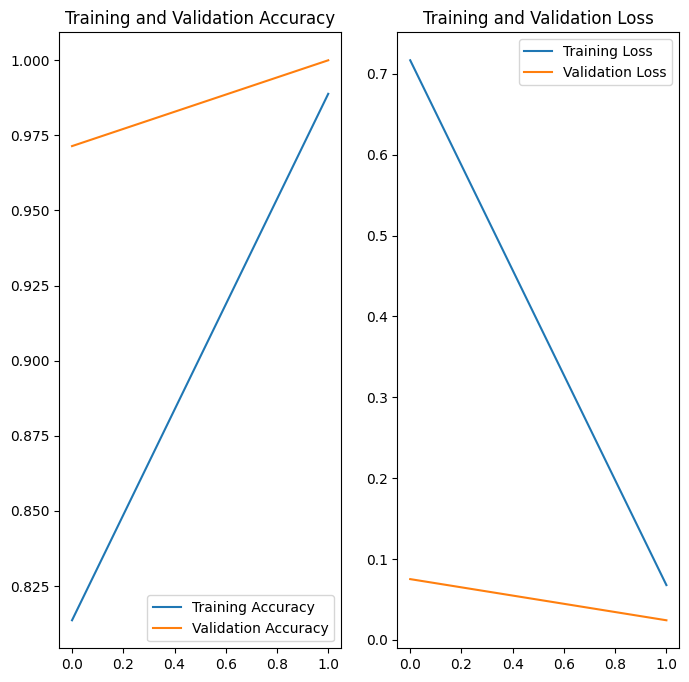

In [19]:
import matplotlib.pyplot as plt
history = result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
loss, accuracy = model.evaluate(x_test, y_test_encoded)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0092
